In [8]:
import sys
import pandas as pd
import msoffcrypto
import io
import seaborn as sns
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import lifelines

print(f"""
versions for reproducibility
    {sns.__version__,=}
    {pd.__version__,=}
    {lifelines.__version__,=}
    {sys.version_info,=}
""")


versions for reproducibility
    sns.__version__,=('0.13.2',)
    pd.__version__,=('2.2.2',)
    lifelines.__version__,=('0.28.0',)
    sys.version_info,=(sys.version_info(major=3, minor=10, micro=8, releaselevel='final', serial=0),)



In [9]:
fpath = 'urodata-munich-moltypes+marker_20.09.2023.xlsx'
passwd = '???'

def tidy_cases(df):
    df["DFS_EVENT"] = ~(df["Relaps"] == "yes")
    df = df.rename({
        "event (death=1)": "OS_EVENT",
        "OS_(m)": "OS",
        "DFS_(m)": "DFS",
        "UICC_stage": "UICC",
    }, axis=1)
    df["DFS"] = df.DFS.fillna(df.OS)
    
    tx = df.pop('Adj_Tx')=="yes"
    cx = df.pop('Adj_Cx')=="yes"
    rx = df.pop('Adj_Rx')=="yes"
    df["ADJ"] = tx | cx | rx
    df["TNM_N"] = df.TNM_N.fillna(0)
    return df


decrypted_workbook = io.BytesIO()
with open(fpath, 'rb') as f:
    office_file = msoffcrypto.OfficeFile(f)
    office_file.load_key(password=passwd)
    office_file.decrypt(decrypted_workbook)

cases = pd.read_excel(decrypted_workbook, sheet_name='ArrayID_parameter')
cases = tidy_cases(cases)
spots = pd.read_excel(decrypted_workbook, sheet_name='ArrayID_spots')
spots["subtype"] = spots.subtype.map({"Sqamous": "Sc/NE"}, na_action="ignore")

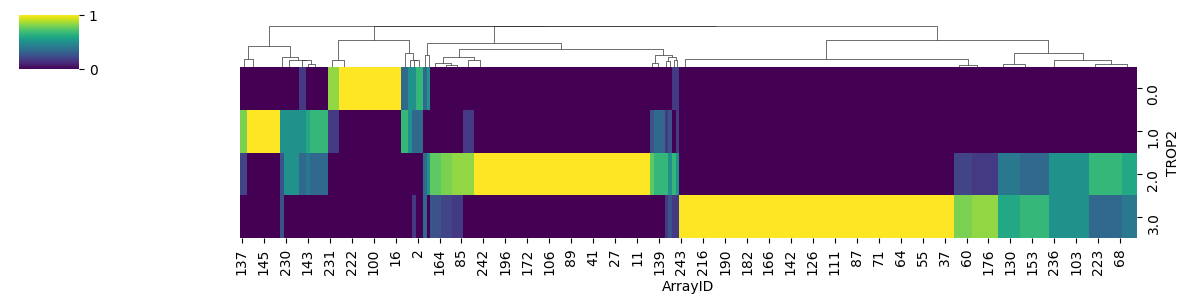

In [10]:
"""
Visualization of score heterogeneity within and across cases
"""

sns.clustermap(
    spots.groupby("ArrayID").TROP2.value_counts(normalize=True).unstack().fillna(0).T,
    method="complete",
    cmap="viridis",
    figsize=(12,3),
    row_cluster=False,
)
plt.savefig("plots/trop2_clustermap.png")

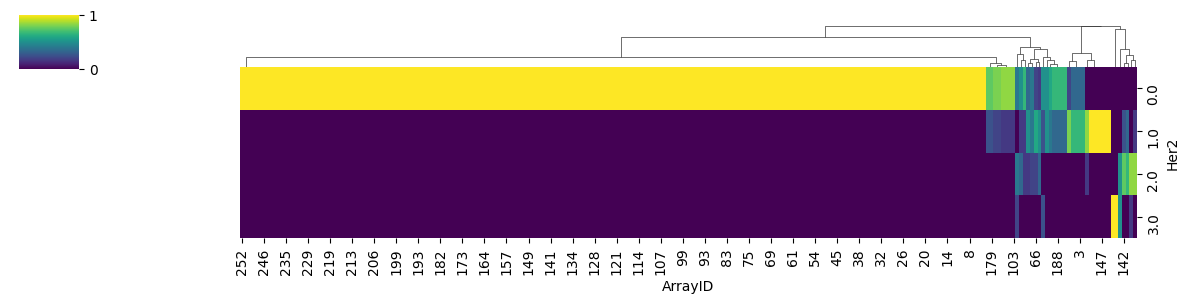

In [11]:
sns.clustermap(
    spots.groupby("ArrayID").Her2.value_counts(normalize=True).unstack().fillna(0).T,
    method="complete",
    cmap="viridis",
    figsize=(12,3),
    row_cluster=False,
)
plt.savefig("plots/her2_clustermap.png")

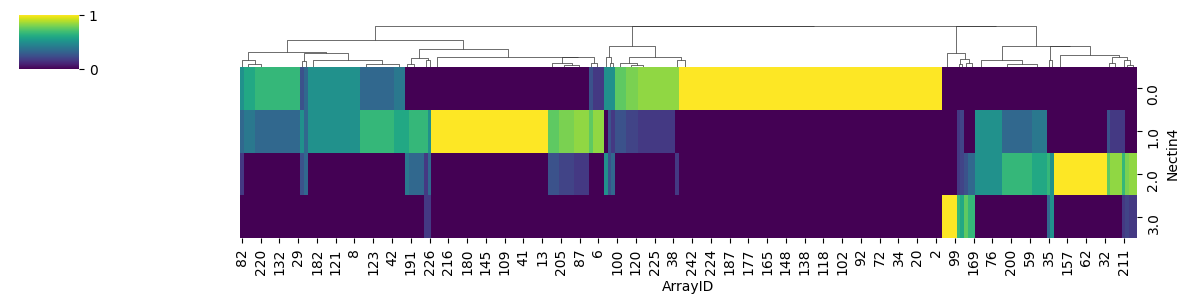

In [12]:
sns.clustermap(
    spots.groupby("ArrayID").Nectin4.value_counts(normalize=True).unstack().fillna(0).T,
    method="complete",
    cmap="viridis",
    figsize=(12,3),
    row_cluster=False,
)
plt.savefig("plots/nectin4_clustermap.png")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 194.75it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

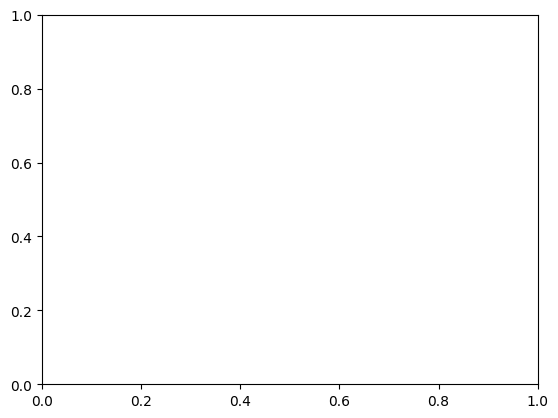

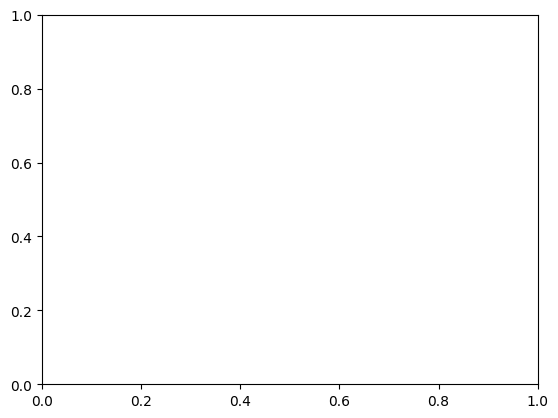

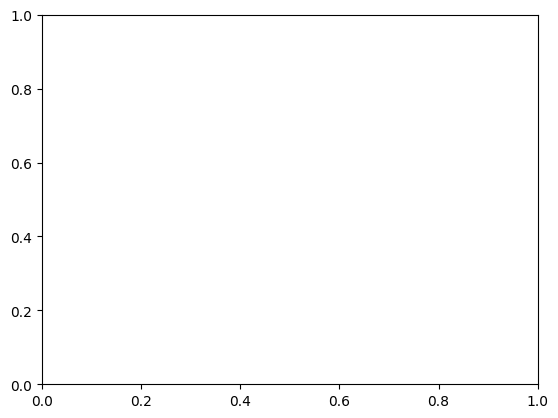

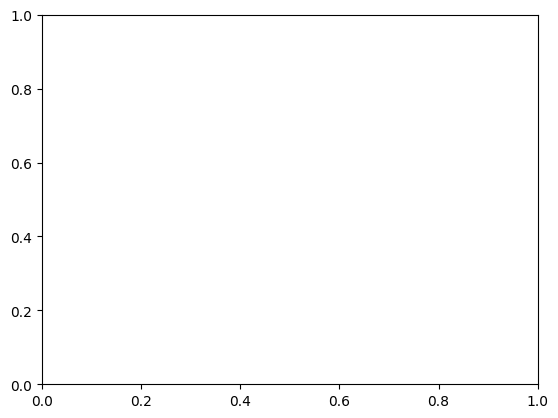

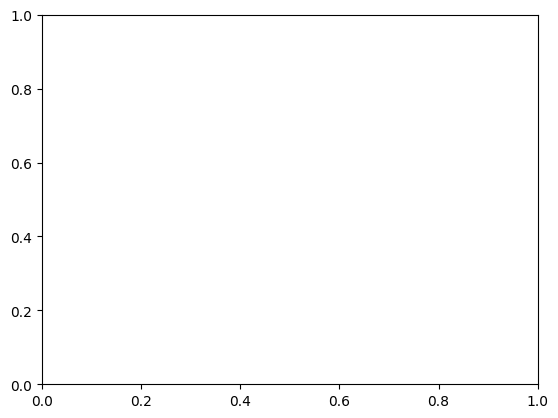

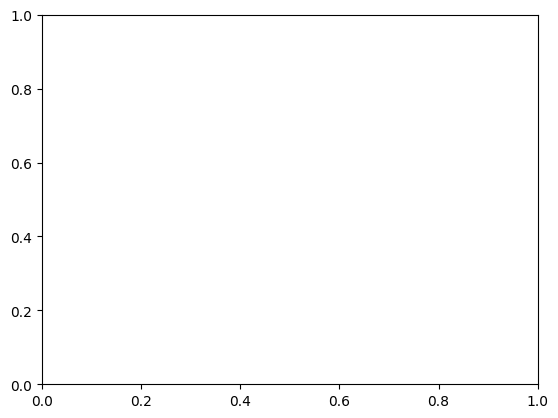

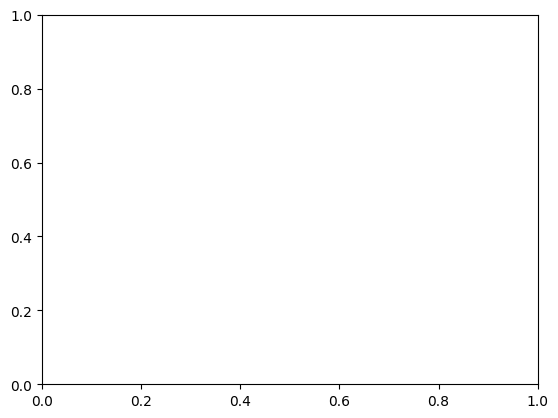

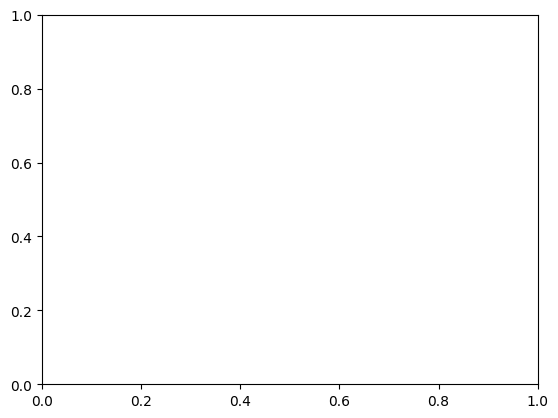

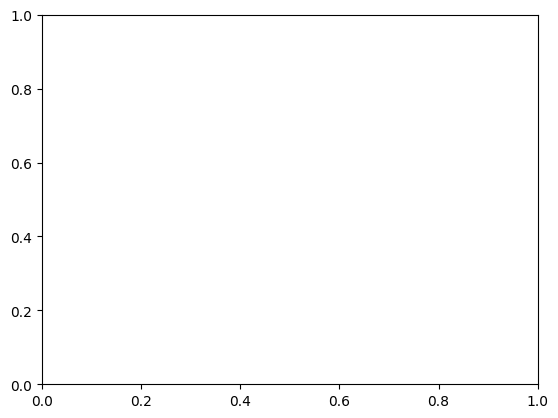

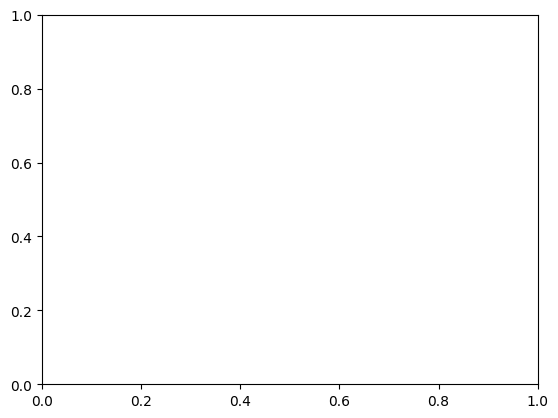

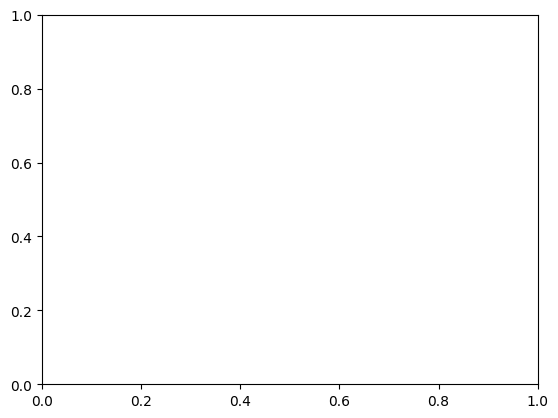

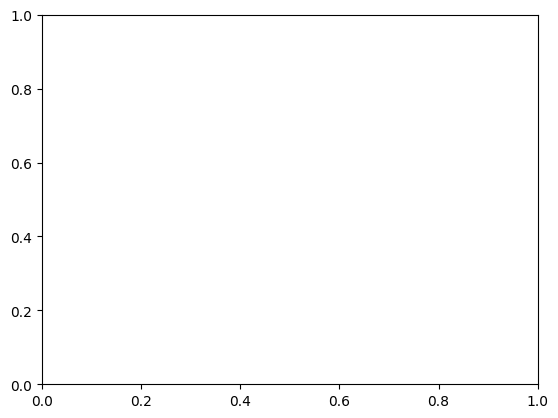

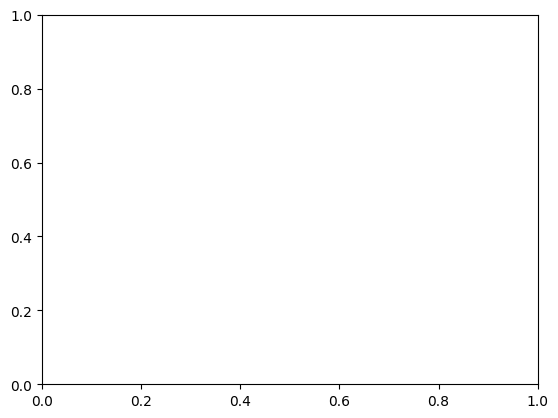

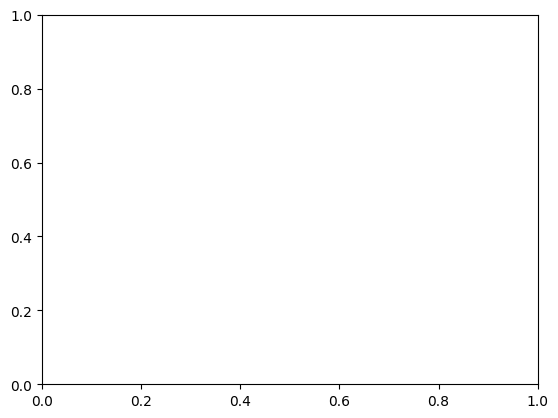

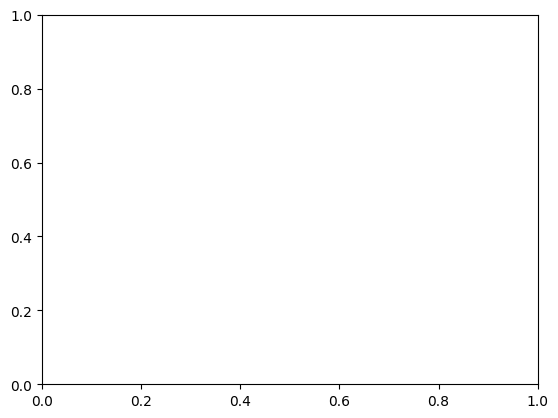

In [13]:
"""
How many spots does it take on average to observe the maximum
expression in cases with expression x
"""

def shuffle_dataframe_and_find_max_index(data_frame):
    """Shuffle the dataframe and return the 1-based index of the maximum value."""
    shuffled_data = data_frame.sample(frac=1).reset_index(drop=True)
    max_value_index = shuffled_data.idxmax(skipna=True) + 1
    return max_value_index

def calculate_max_index_for_groups(data_subset):
    """Apply the max index calculation for each group identified by 'ArrayID'."""
    return data_subset.groupby("ArrayID").apply(shuffle_dataframe_and_find_max_index, include_groups=False)

def normalize_series_index(series):
    """Normalize series index to the fraction of total index count."""
    indices = list(series.index)
    normalized_indices = [index / len(indices) for index in indices]
    series.index = normalized_indices
    return series

def plot_simulation_results(average_outcomes, biomarker, threshold):
    """Create and save a plot of the simulation results."""
    fig, ax = plt.subplots()
    average_outcomes.sort_values(by=biomarker).reset_index(drop=True).pipe(normalize_series_index).plot(ax=ax, legend=False)
    ax.set_xlabel("Patient sorted by value")
    ax.set_ylabel("Average number of draws until max is observed")
    ax.set_title(f"For cases with maximum score equal {threshold}\n average number of draws required to \n observe maximum score in {biomarker}")
    plt.savefig(f"plots/sampling_{biomarker}_max_{threshold}.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

def analyze_max_value_distribution(data, biomarker, threshold, num_simulations):
    """Perform simulation to evaluate the distribution of max value indices across samples."""
    filtered_data = data[["ArrayID", biomarker]].dropna()
    valid_counts = filtered_data.groupby("ArrayID")[biomarker].count()
    filtered_data = filtered_data[filtered_data["ArrayID"].isin(valid_counts[valid_counts >= 4].index)]
    
    if threshold is not None:
        max_values = filtered_data.groupby("ArrayID")[biomarker].max()
        filtered_data = filtered_data[filtered_data["ArrayID"].isin(max_values[max_values == threshold].index)]

    simulation_results = [calculate_max_index_for_groups(filtered_data) for _ in tqdm(range(num_simulations))]
    average_outcomes = pd.concat(simulation_results).reset_index().groupby("ArrayID").mean()
    
    plot_simulation_results(average_outcomes, biomarker, threshold)

n_runs = 400
[
    analyze_max_value_distribution(spots, marker, threshold, n_runs)
    for marker in ["TROP2", "Her2", "Nectin4"]
    for threshold in [None, 0, 1, 2, 3]
]

In [20]:
"""
Ring plots for number of cases with a maximum expression of {int} per {marker}
"""
sub = spots.drop(["subtype", "Location"], axis=1).groupby("ArrayID").max()

for col in sub.columns:
    sub[col].value_counts().sort_index().plot.pie(wedgeprops=dict(width=0.3, edgecolor='w'))
    plt.title(col)
    plt.savefig(f"plots/{col=}_bar.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [19]:
sub = spots.drop(["subtype"], axis=1).groupby(["ArrayID", "Location"]).max().reset_index()
for location in ['Center', 'Front']:
    subloc = sub.query(f"Location=='{location}'")
    subloc = subloc.set_index("ArrayID")
    for col in subloc.columns:
        # subloc[col].value_counts().plot.pie()
        subloc[col].value_counts().sort_index().plot.pie(wedgeprops=dict(width=0.3, edgecolor='w'))
        plt.title(f"{col} {location}")
        plt.savefig(f"plots/{col=}_{location}_bar.png")
        plt.clf()

<Figure size 640x480 with 0 Axes>

In [21]:
# maxx = cases.merge(spots.groupby("ArrayID").max(), on="ArrayID")
maxx = cases.merge(spots.drop(["Location", "subtype"], axis=1).groupby("ArrayID").max(), on="ArrayID")

In [22]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import multivariate_logrank_test
import numpy as np

def kmfplots(
    target: pd.DataFrame, 
    group_key: str, 
    dur_key: str, 
    event_key: str,
    fpath: str,
):
    """
    target data frame should have columns
    DUR: (0, +inf]
        survival duration most often in months
    EVENT: {0, 1} 
        where 1 indicates that the event was observed at time t, and 0 if event is censored
    risk_strata: int
        subgroups of the cohort to compare in the figure (inkl. logrank test)
    """
    
    def kmfplot(group_val, sub, ax):
        """helper for `kmfplots`"""
        kmf = KaplanMeierFitter(label=f"{group_key}={group_val}")
        kmf.fit(sub[dur_key], sub[event_key], timeline=np.linspace(0, 60, 1000))
        kmf.plot(
            ax=ax,
            label=f"{group_key}={group_val}\n"
                  f"median {kmf.median_survival_time_:.1f}",
            ci_show=False,
            show_censors=True,
            censor_styles={"marker": "|", "ms": 5},
        )
        return kmf


    plt.figure(figsize=(9, 9))
    ax = plt.subplot(111)
    
    kmfs = [
        kmfplot(group_val, sub, ax) 
        for group_val, sub 
        in target.groupby(group_key)
    ]
    add_at_risk_counts(*kmfs, ax=ax)
    test = multivariate_logrank_test(
        event_durations=target[dur_key],
        groups=target[group_key],
        event_observed=target[event_key],
    )
    
    ax.set_title(f"{dur_key} by {group_key} \n logrank test (p={test.p_value:.3f})")
    plt.ylim(0.3, 1.05)
    plt.tight_layout()
    if fpath:
        plt.savefig(fpath)
    plt.show()
    

In [32]:
def write_string(fpath, msg):
    with open(fpath, "w") as f:
        f.write(msg)

tmp = maxx[["TROP2", "Her2", "Nectin4"]].apply(lambda x: x.value_counts())
msg = tmp.to_markdown(tablefmt="psql")
write_string("plots/crosstab_absolute_markers.txt", msg)

In [33]:
tmp = maxx[["TROP2", "Her2", "Nectin4"]].apply(lambda x: x.value_counts(normalize=True).mul(100).round(1))
msg = tmp.to_markdown(tablefmt="psql")
write_string("plots/crosstab_relative_markers.txt", msg)

In [34]:
"""
Contingency tables –
Statistical association of markers with clinical metadata
"""

from scipy.stats import chi2_contingency

def contingency_table_plot(df, col_mark, col_meta):
    # get contingency table
    table = df[[col_mark, col_meta]].value_counts().unstack().fillna(0)
    msg = table.to_markdown(tablefmt="psql")
    write_string(f"plots/crosstab_{col_mark}_{col_meta}.txt", msg)
    # test and plot
    pval = chi2_contingency(table)[1]
    normalized = 100*(table.T / table.T.sum()).T
    normalized.plot.bar(stacked=True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title=col_meta.replace("_", " "))
    plt.title(f"chi-square test p-value {pval:.2E}{'*' if pval<0.05 else ''}")
    plt.savefig(f"plots/barplot_{col_mark}_{col_meta}.png", bbox_inches='tight')
    plt.close()

[
    contingency_table_plot(maxx, marker, meta)
    for marker in ["TROP2", "Her2", "Nectin4"]
    for meta in ["UICC", "gender", "Tumor_subtype", "TNM_T_r", "TNM_N", "TNM_V", "TNM_L"]
];

In [36]:
def write_string(fpath, msg):
    with open(fpath, "w") as f:
        f.write(msg)

tmp = spots.drop("subtype", axis=1).groupby(["Location", "ArrayID"]).max()
tmp = tmp.groupby("Location").apply(lambda x: x.apply(lambda y: y.value_counts(normalize=True).mul(100).round(1)))
msg = tmp.to_markdown(tablefmt="psql")
write_string("plots/crosstab_max_spot_per_marker_per_location.txt", msg)

In [63]:
for marker in ["Her2", "Nectin4", "TROP2"]:
    filtering = spots.groupby("ArrayID")[marker].mean().gt(0)
    keepidx = filtering[filtering].index
    
    diff = (spots.query("ArrayID in @keepidx")
     .dropna(subset=marker)
     .groupby(["ArrayID", "Location"])[marker].mean()
     .groupby(["ArrayID"]).diff().loc[:, "Front"]
     #.mean()
    )
    
    diffps = []
    for _ in tqdm(range(1_000)):
        tmp = spots.copy().query("ArrayID in @keepidx")
        tmp["Location"] = tmp.sample(frac=1., replace=False).Location.values
        diffp = (tmp
             .dropna(subset=marker)
             .groupby(["ArrayID", "Location"])[marker].mean()
             .groupby(["ArrayID"]).diff().loc[:, "Front"]
             .mean()
        )
        diffps.append(diffp)
    
    plt.figure(figsize=(12, 3))
    plt.subplot(121)
    plt.plot(diff.sort_values().values)
    plt.title(f"{marker} Expression Difference from \nTumor Front to Center Across Patients")
    plt.xlabel(f"Per Patient Average {marker} Expression \nDifference (Front vs Center)")
    plt.ylabel(f"Patient Index \n(Sorted by Expression Difference)")
    plt.subplot(122)
    pd.Series(diffps).plot.kde()
    plt.axvline(diff.mean(), c="C1")
    plt.title(f"Permutation Test: H0 Distribution (blue) vs\n Observed Her2 Expression Differences (orange), \np-value = {np.mean(np.abs(diffps) > np.abs(diff.mean()))}")
    plt.xlabel(f"Mean {marker} Expression \nDifference (Front vs Center)")
    plt.savefig(f"plots/diff_center_to_front_{marker}.png", bbox_inches='tight')
    plt.clf()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.53it/s]


<Figure size 1200x300 with 0 Axes>

<Figure size 1200x300 with 0 Axes>

<Figure size 1200x300 with 0 Axes>

In [64]:
# is survival in the postivie cases correlated
coll = {}
for marker in ["Her2", "TROP2", "Nectin4"]:
    filtering = spots.groupby("ArrayID")[marker].mean().gt(0)
    keepidx = filtering[filtering].index
    
    diff = (spots.query("ArrayID in @keepidx")
     .dropna(subset=marker)
     .groupby(["ArrayID", "Location"])[marker].mean()
     .groupby(["ArrayID"]).diff().loc[:, "Front"]
    ).dropna()
    diff = diff.to_frame(marker).reset_index()
    
    tmp = (cases.merge(diff, on="ArrayID")
           .assign(gender=lambda x: x.gender=="male")
           .assign(neoTx=lambda x: x.neoTx=='yes')
           .assign(logage=lambda x: np.log1p(x["Age_at_diagnosis_(y)"]))
          )
    tmp = pd.concat([tmp, pd.get_dummies(tmp.Tumor_subtype.astype("category"))], axis=1)
    from lifelines.fitters.coxph_fitter import CoxPHFitter
    cph = CoxPHFitter()
    cph.fit(df=tmp[[
        "DFS", "DFS_EVENT",
        marker, 
        "ADJ", "UICC", "logage"
    ]], duration_col="DFS", event_col="DFS_EVENT")
    cph.summary
    cph.summary.to_markdown(f"plots/cox_regression_dfs_{marker}.md", tablefmt="psql")
    # coll[marker] = cph.summary.loc[marker]
    coll[marker] = cph.summary

In [65]:
for key in coll.keys():
    tmp = coll[key][["coef", "coef lower 95%", "coef upper 95%"]].T.melt(var_name="covariate", value_name="hazard_ratio")
    sns.pointplot(
        tmp, 
        x="hazard_ratio", 
        y="covariate", 
        errorbar=lambda x: (x.min(), x.max()),
        estimator="median",
        linestyle="none",
    )
    plt.axvline(0, linestyle='--')
    plt.savefig(f"plots/{key}_forest_plot.png", dpi=600)
    plt.clf()

<Figure size 640x480 with 0 Axes>